# **initials**

In [1]:
!cp -r drive/MyDrive/ml_project ./ml_project

In [2]:
# Import the necessary modules
from osgeo import gdal
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
# Open the GeoTIFF files using GDAL
datasetTrainingGT = gdal.Open('ml_project/S2A_MSIL1C_20220516_Train_GT.tif')

# Read the data from the first GeoTIFF file into a NumPy array
trainGT2d = datasetTrainingGT.ReadAsArray()
trainGT2d = np.swapaxes(trainGT2d, 0, 1)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
trainGT1d = trainGT2d.reshape(trainGT2d.shape[0] * trainGT2d.shape[1], 1)

# Convert the combined array into a Pandas DataFrame
dfTrainLabels = pd.DataFrame(trainGT1d)

# Export the DataFrame as a CSV file
# dfTrainLabels.to_csv('train.csv', index=False)
np.save('train_gt.npy', trainGT1d)

datasetTraining = gdal.Open('ml_project/S2A_MSIL1C_20220516_TrainingData.tif')

# Read the data from the first GeoTIFF file into a NumPy array
dataTraing = datasetTraining.ReadAsArray()
dataTraing = np.swapaxes(dataTraing, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTraining1d = dataTraing.reshape(dataTraing.shape[0] * dataTraing.shape[1], -1)
dfTrain = pd.DataFrame(dataTraining1d)

final_data = pd.concat([dfTrainLabels, dfTrain])

train_label_data = pd.concat([dfTrainLabels, dfTrain], axis=1)
train_label_data.columns=['Code', 'Blue', 'Green', 'Red', 'NIR']
train_label_data.to_csv('train.csv')

np.save('train.npy', dataTraining1d)


datasetTest = gdal.Open('ml_project/S2B_MSIL1C_20220528_Test.tif')

# Read the data from the first GeoTIFF file into a NumPy array
dataTest2d = datasetTest.ReadAsArray()
dataTest2d = np.swapaxes(dataTest2d, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTest1d = dataTest2d.reshape(dataTest2d.shape[0] * dataTest2d.shape[1], -1)
np.save('test_all.npy', dataTest1d)
# Convert the combined array into a Pandas DataFrame
dfTest = pd.DataFrame(dataTest1d)
dfTest.columns=['Blue', 'Green', 'Red', 'NIR']
# Export the DataFrame as a CSV file
dfTest.to_csv('test.csv')

# **remove data with 0's**

In [4]:
#remove 0's
zero_row_indices = np.argwhere(~dataTraining1d.any(axis=1))
np_train = dataTraining1d[dataTraining1d != 0]
np_train_gt = np.delete(np.ravel(trainGT1d), zero_row_indices, axis=0)
np_train = np_train.reshape(965708, 4)

# **split**

In [5]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(np_train, np_train_gt, random_state=0, train_size = .7)

# **knn**

In [ ]:
clf = KNeighborsClassifier(n_neighbors=39)
score = cross_val_score(clf, np_train, np_train_gt, cv=5)
acc = score.mean()
print(acc)

0.8916659885268391


In [7]:
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors=39)
clf.fit(train_features, train_labels)
end_time = time.time() - start_time
print("training time for knn: %f" % end_time)

training time for knn: 1.082270


In [14]:
start_time = time.time()
predictions_knn = clf.predict(test_features)
end_time = time.time() - start_time
print("prediction time for knn: %f" % (end_time))

prediction time for knn: 3.289200


# **bayes**

In [ ]:
model = GaussianNB()
scores = cross_val_score(model, np_train, np_train_gt, cv=5)
acc = scores.mean()
print(acc)

0.8379365245831754


In [9]:
model = GaussianNB()

start_time = time.time()
model.fit(train_features, train_labels)
end_time = time.time() - start_time
print("training time for bayes: %f" % end_time)

training time for bayes: 0.204697


In [11]:
start_time = time.time()
predictions_bayes = model.predict(test_features)
end_time = time.time() - start_time
print("prediction time for bayes: %f" % (end_time))

prediction time for bayes: 0.350258


# **random forest**

In [ ]:
clf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

scores = cross_val_score(clf, np_train, np_train_gt, cv=5)
acc = scores.mean()
print(acc)

0.8905041440919185


In [12]:
clf = RandomForestClassifier(criterion="gini",
                             max_depth=8,
                             min_samples_split=10,
                             random_state=5)

start_time = time.time()
clf.fit(train_features, train_labels)
end_time = time.time() - start_time
print("training time for random forest: %f" % end_time)

training time for random forest: 101.266686


In [13]:
start_time = time.time()
predictions_rf = clf.predict(test_features)
end_time = time.time() - start_time
print("prediction time for random forest: %f" % (end_time))

prediction time for random forest: 3.299861


# **save**

In [ ]:
sub_df = pd.DataFrame(predictions_knn)
sub_df.index.names = ['Id']
sub_df.columns=['Code']

sub_df.to_csv('knn_1.csv')

In [ ]:
sub_df = pd.DataFrame(predictions_bayes)
sub_df.index.names = ['Id']
sub_df.columns=['Code']

sub_df.to_csv('bayes_1.csv')

In [ ]:
sub_df = pd.DataFrame(predictions_rf)
sub_df.index.names = ['Id']
sub_df.columns=['Code']

sub_df.to_csv('rf_1.csv')

# **conf matrices**

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

            Tree cover       0.00      0.00      0.00       138
             Shrubland       0.73      0.60      0.66     17370
             Grassland       0.58      0.39      0.47      4783
              Cropland       0.68      0.77      0.72     32584
              Built-up       0.00      0.00      0.00      1303
Bare/sparse vegetation       0.77      0.90      0.83     42839
          Snow and ice       0.71      0.17      0.28      4399
Permanent water bodies       0.99      0.99      0.99    185780
    Herbaceous wetland       0.00      0.00      0.00       517

              accuracy                           0.90    289713
             macro avg       0.50      0.42      0.44    289713
          weighted avg       0.89      0.90      0.89    289713



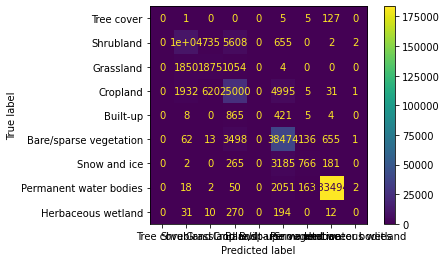

In [15]:
# Compute the confusion matrix - knn
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_knn)
print(classification_report(test_labels, predictions_knn,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

            Tree cover       0.00      0.00      0.00       138
             Shrubland       0.41      0.41      0.41     17370
             Grassland       0.28      0.86      0.42      4783
              Cropland       0.61      0.51      0.55     32584
              Built-up       0.00      0.00      0.00      1303
Bare/sparse vegetation       0.75      0.79      0.77     42839
          Snow and ice       0.00      0.00      0.00      4399
Permanent water bodies       0.99      0.98      0.98    185780
    Herbaceous wetland       0.00      0.00      0.00       517

              accuracy                           0.84    289713
             macro avg       0.34      0.39      0.35    289713
          weighted avg       0.84      0.84      0.84    289713



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


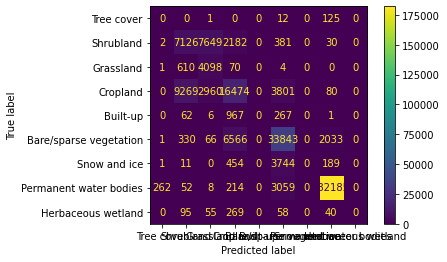

In [16]:
# Compute the confusion matrix - bayes
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_bayes)
print(classification_report(test_labels, predictions_bayes,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

            Tree cover       0.00      0.00      0.00       138
             Shrubland       0.73      0.60      0.66     17370
             Grassland       0.58      0.39      0.47      4783
              Cropland       0.68      0.77      0.72     32584
              Built-up       0.00      0.00      0.00      1303
Bare/sparse vegetation       0.77      0.90      0.83     42839
          Snow and ice       0.71      0.17      0.28      4399
Permanent water bodies       0.99      0.99      0.99    185780
    Herbaceous wetland       0.00      0.00      0.00       517

              accuracy                           0.90    289713
             macro avg       0.50      0.42      0.44    289713
          weighted avg       0.89      0.90      0.89    289713



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


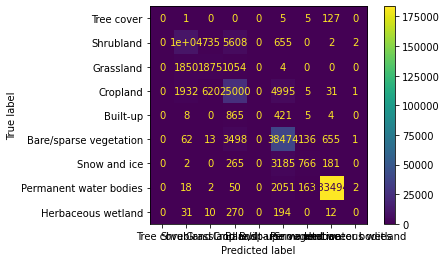

In [17]:
# Compute the confusion matrix - random forest
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies', 'Herbaceous wetland']

cm = confusion_matrix(test_labels, predictions_rf)
print(classification_report(test_labels, predictions_rf,target_names=labels))
# print(cm)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()